In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
nationalilty = {
    'USA': 'american',
    'Germany': 'german',
    'Cuba': 'cuban',
    'Brazil': 'brazilian',
    'France': 'french',
    'Great Britain': 'british',
    'Kenya': 'kenyan',
    'Finland': 'finnish',
    'Japan': 'japanese',
    'China': 'chinese',
    'Nigeria': 'nigerian',
    'Tanzania': 'tanzanian',
    'Korea': 'korean',
    'Vietnam': 'vietnamese'
}

In [3]:
all_countries = [
    'USA',
    'Cuba',
    'Brazil',
    'Germany',
    'France',
    'Great Britain',
    'Finland',
    'Japan',
    'China',
    'Korea',
    'Vietnam',
    'Kenya',
    'Nigeria',
    'Tanzania',
]

In [4]:
# This pickled dictionary contains the perturbed first paragraph of the biographies that were used for the paper.
with open('./sampled_data.pk', 'rb') as fin:
    sampled_data = pickle.load(fin)

In [5]:
# For example, to get the set of perturbed biographies where the original entity was a USA national 
# and the new entity is a Japanese national, we execute the code below:
sampled_data['USA']['Japan'][:2] # Just display the first two

[{'original_entity': 'William Bast',
  'original_nationality': 'USA',
  'original_article': 'William Bast was an American screenwriter and author. In addition to writing scripts for motion pictures and television, he was the author of two biographies of the screen actor James Dean. He often worked with his partner Paul Huson.',
  'new_entity': 'Chōsokabe Kunichika',
  'new_nationality': 'Japan',
  'new_article': 'Chōsokabe Kunichika was an American screenwriter and author. In addition to writing scripts for motion pictures and television, he was the author of two biographies of the screen actor James Dean. He often worked with his partner Paul Huson.'},
 {'original_entity': 'William Bast',
  'original_nationality': 'USA',
  'original_article': 'William Bast was an American screenwriter and author. In addition to writing scripts for motion pictures and television, he was the author of two biographies of the screen actor James Dean. He often worked with his partner Paul Huson.',
  'new_e

In [6]:
# This pickled dictionary contains generated summaries for all the models used in the paper.
with open('./all_summaries.pk', 'rb') as fin:
    all_summaries = pickle.load(fin) 

In [7]:
# Top-level key is the model, and value is a dictionary, where the key is the article and value is the generated summary.
all_summaries.keys()

dict_keys(['bart-xsum-finetuned', 'pegasus-xsum-finetuned', 'bart-nyt-finetuned', 'bart-cnndm-finetuned', 'bart-xsum-adapter', 'bart-xsum-last-layer'])

In [8]:
def process_data(data, model):
    context_nationality = [] # Keeps track of instances where the model generated the correct nationality
    orig_nationality = [] # keeps track of instances where the model hallucinated nationality based on inserted entity
    rest = []
    
    for item in data:
        nat_cont = nationalilty[item['original_nationality']] # What nationality should be, according to context.
        nat_orig = nationalilty[item['new_nationality']] # Nationality of the inserted entity
        orig_entity = item['original_entity']
        new_article = item['new_article']
        count_orig = item['new_nationality'].lower() # Country for inserted entity
        count_cont = item['original_nationality'].lower() # Country according to context
        summary = all_summaries[model][item['new_article']]
        
        if any([x.lower() in new_article.lower() for x in orig_entity.split()]):
            continue
        if nat_orig.lower() in new_article.lower() or count_orig in new_article.lower():
            continue
            
        if (nat_orig in summary.lower() or count_orig in summary.lower()):
            # If we see the nationality of the entity we insert, we have a hallucination!
            orig_nationality.append((item, summary, item['new_article']))
        elif nat_cont in summary.lower() or count_cont in summary.lower():
            # Model correctly generates nationality information based on provided context
            context_nationality.append((item, summary, item['new_article']))
        else:
            rest.append((item, summary))
    return context_nationality, orig_nationality, rest

In [9]:
# For example, to process the data for USA -> Japan substitution for bart-xsum-fintuned
cont, orig, rest = process_data(sampled_data['USA']['Japan'], 'bart-xsum-finetuned')

In [10]:
len(orig)/(len(cont) + len(orig) + len(rest)) #hallucination rate for USA -> Japan

0.40789473684210525

In [11]:
# This computes hallucination rates for all 
hallucination = {}
for model in all_summaries.keys():
    halluc = {}
    for i in range(0, len(all_countries)):
        country_a = all_countries[i]
        if country_a not in halluc:
            halluc[country_a] = {}
        for j in range(0, len(all_countries)):
            country_b = all_countries[j]
            if country_b == country_a:
                halluc[country_a][country_b] = 0
            else:
                cont, orig, rest = process_data(sampled_data[country_a][country_b], model)
                halluc[country_a][country_b] = len(orig)/(len(cont)+len(orig)+len(rest))
    hallucination[model] = halluc

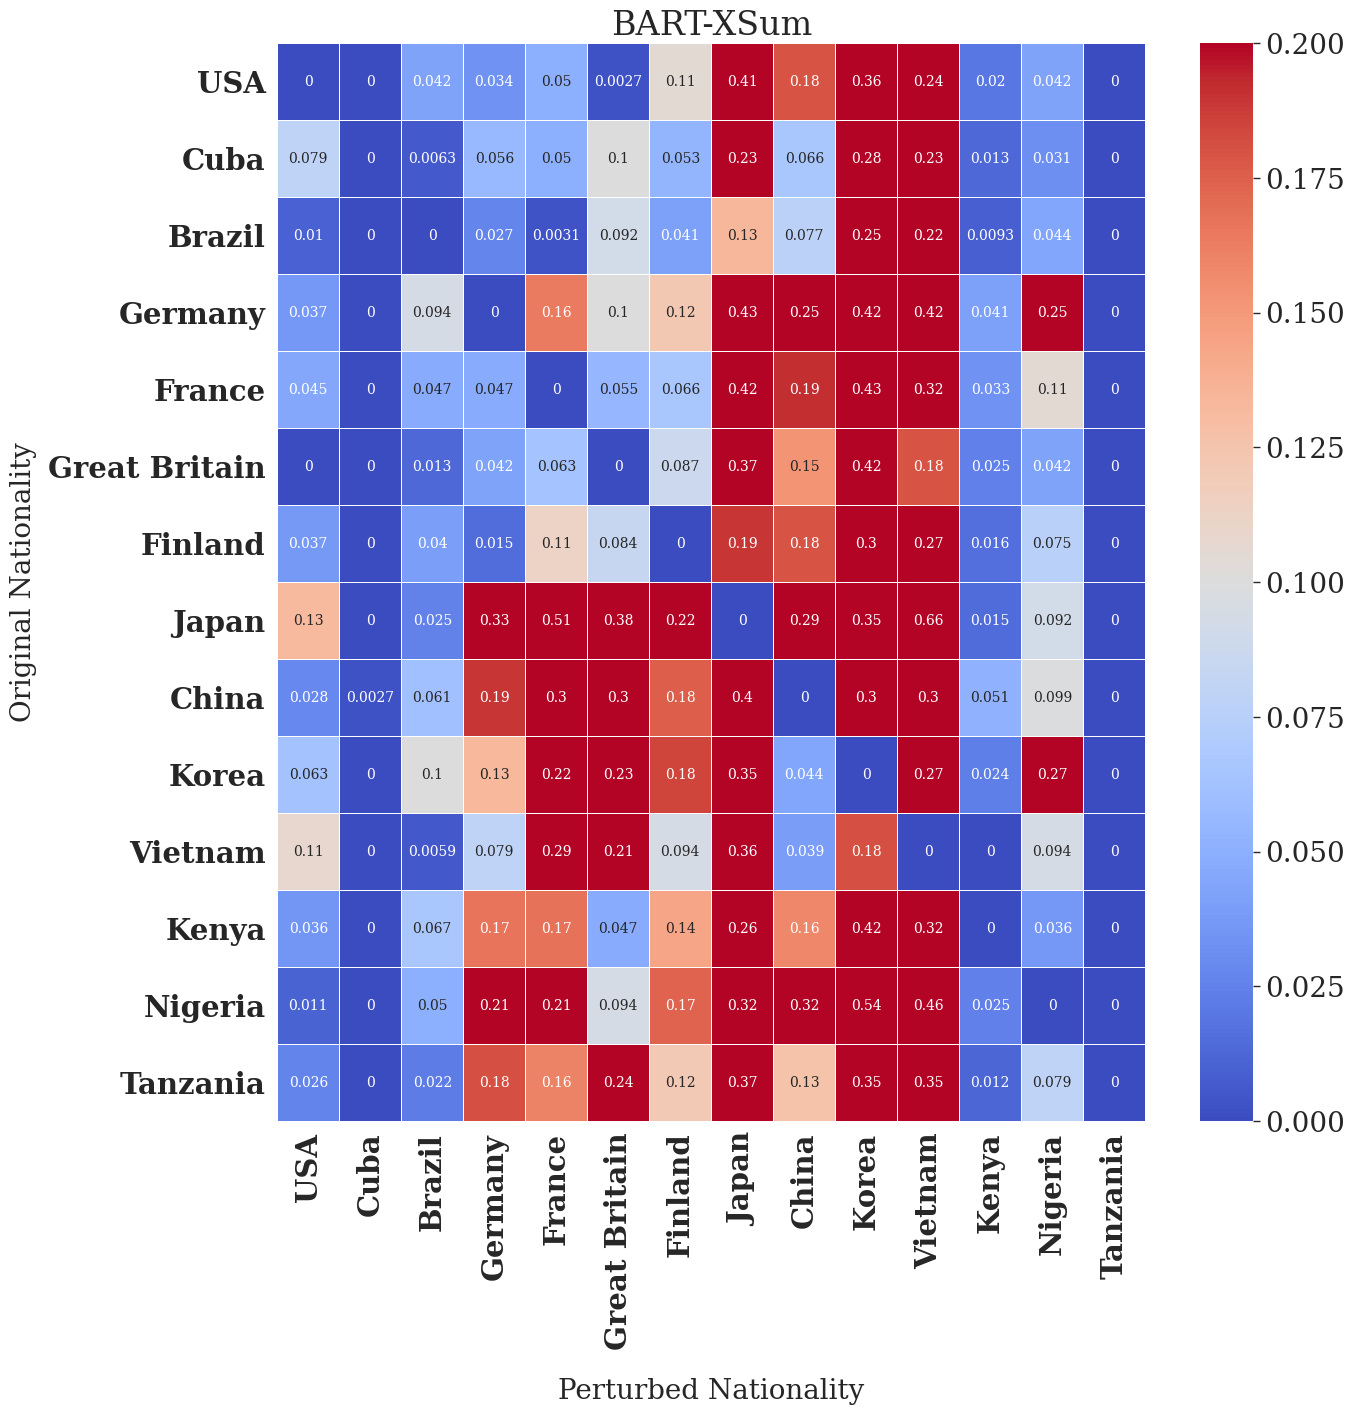

In [12]:
# This plots the heatmap based on hallucination rates.
# For example, we plot Bart-XSUM, as we did for the paper. 
model_name = 'bart-xsum-finetuned'

%matplotlib inline
sns.set_style({'font.family':'serif', 'font.serif':'Arial'})
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
df = pd.DataFrame(hallucination[model_name])
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df.transpose(), cmap='coolwarm', vmin=0, vmax=.2,  linewidths=0.1, cbar = True, annot=True, annot_kws={"fontsize":10})
plt.xlabel('Perturbed Nationality', fontsize=20, labelpad=20)
plt.ylabel('Original Nationality', fontsize=20, labelpad=8)
plt.yticks(rotation=0, fontsize=21, weight='bold')
plt.xticks(rotation=90,fontsize=21, weight='bold')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title("BART-XSum",fontsize=24)
plt.show()